In [1]:
import json
import os
from scipy.optimize import curve_fit, minimize
from scipy.special import erf
from scipy.stats import iqr
import matplotlib
import matplotlib.pyplot as plt
from qcelemental import constants
import numpy as np
import logging
import warnings
from functions import prettifyBasis
from uncertainties import ufloat, umath
matplotlib.rcParams.update({'font.size': 14})

In [2]:
medianprops = dict(linestyle='-', linewidth=2.5)
meanprops = dict(linestyle='-', linewidth=2.5, color="black")

In [3]:
log = logging.getLogger()
log.setLevel("WARNING")
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
log.addHandler(ch)

In [4]:
jsons = [f for f in os.listdir(os.path.join("..", "data", "diatomics")) if f.endswith("json") and f.startswith("pbe")]
pbedata = {}
for fn in jsons:
    items = fn.replace(".json","").split("_")[1:]
    ac = 100 - float(items[0])
    ax = float(items[1])
    if ac not in pbedata:
        pbedata[ac] = {}
    if ax not in pbedata[ac]:
        pbedata[ac][ax] = {}
    with open(os.path.join("..", "data", "diatomics", fn), "r") as jsfile:
         fncontents = json.load(jsfile)
    pbedata[ac][ax][items[2]] = fncontents

In [5]:
jsons = [f for f in os.listdir(os.path.join("..", "data", "HelFEM")) if f.endswith("json") and f.startswith("pbe")]
for fn in jsons:
    items = fn.replace(".json","").split("_")[1:]
    ac = 100 - float(items[0])
    ax = float(items[1])
    if ac not in pbedata:
        pbedata[ac] = {}
    if ax not in pbedata[ac]:
        pbedata[ac][ax] = {}
    with open(os.path.join("..", "data", "HelFEM", fn), "r") as jsfile:
         fncontents = json.load(jsfile)
    pbedata[ac][ax]["lim"] = fncontents[f"HYB_GGA_XC_PBE_{items[0]}_{items[1]}"]

In [6]:
def expsqrt(X, α, A):
    #return Einf + A * np.exp(-α * np.sqrt(X))
    return np.log(A) - abs(α) * np.sqrt(X)

In [7]:
basisfamilies = {
    "cc-pvXz":         [["cc-pvdz", 2], ["cc-pvtz", 3], ["cc-pvqz", 4], ["cc-pv5z", 5], ["cc-pv6z", 6]],
    "cc-pwcvXz":       [["cc-pwcvdz", 2], ["cc-pwcvtz", 3], ["cc-pwcvqz", 4], ["cc-pwcv5z", 5]],
    "aug-cc-pvXz":     [["aug-cc-pvdz", 2], ["aug-cc-pvtz", 3], ["aug-cc-pvqz", 4], ["aug-cc-pv5z", 5], ["aug-cc-pv6z", 6]],
    "aug-cc-pwcvXz":   [["aug-cc-pwcvdz", 2], ["aug-cc-pwcvtz", 3], ["aug-cc-pwcvqz", 4], ["aug-cc-pwcv5z", 5]],
    "def2-Xzvp":       [["def2-svp", 2], ["def2-tzvp", 3], ["def2-qzvp", 4]],
    "def2-Xzvpp":      [["def2-svp", 2], ["def2-tzvpp", 3], ["def2-qzvpp", 4]],
    "def2-Xzvpd":      [["def2-svpd", 2], ["def2-tzvpd", 3], ["def2-qzvpd", 4]],
    "def2-Xzvppd":     [["def2-svpd", 2], ["def2-tzvppd", 3], ["def2-qzvppd", 4]],
    "pc-N":            [["pc-0", 1], ["pc-1", 2], ["pc-2", 3], ["pc-3", 4], ["pc-4", 5]],
    "pcseg-N":         [["pcseg-0", 1], ["pcseg-1", 2], ["pcseg-2", 3], ["pcseg-3", 4], ["pcseg-4", 5]],
    "aug-pc-N":        [["aug-pc-0", 1], ["aug-pc-1", 2], ["aug-pc-2", 3], ["aug-pc-3", 4], ["aug-pc-4", 5]],
    "aug-pcseg-N":     [["aug-pcseg-0", 1], ["aug-pcseg-1", 2], ["aug-pcseg-2", 3], ["aug-pcseg-3", 4], ["aug-pcseg-4", 5]],
    "Xzapa-nr":        [["2zapa-nr", 2], ["3zapa-nr", 3], ["4zapa-nr", 4], ["5zapa-nr", 5], ["6zapa-nr", 6]],# ["7zapa-nr", 7]],
    "Xzapa-nr-cv":     [["2zapa-nr-cv", 2], ["3zapa-nr-cv", 3], ["4zapa-nr-cv", 4], ["5zapa-nr-cv", 5]],
    "jorge-Xzp":       [["jorge-dzp", 2], ["jorge-tzp", 3], ["jorge-qzp", 4], ["jorge-5zp", 5], ["jorge-6zp", 6]],
    "jorge-aXzp":      [["jorge-adzp", 2], ["jorge-atzp", 3], ["jorge-aqzp", 4], ["jorge-a5zp", 5]],
}

In [8]:
αs = {}
totals = {}
for ac in [0.0, 20.0, 40.0, 60.0]:
    αs[ac] = {}
    totals[ac] = {}
    for ax in [0.0, 10.0, 30.0, 50.0, 70.0, 90.0]:
        if ax == 0.0 and ac > 0:
            continue
        αs[ac][ax] = {}
        count = 0
        for diatomic in pbedata[ac][ax]["lim"]:
            if not diatomic.startswith("1"):
                continue
            if "Iteration 50" in pbedata[ac][ax]["lim"][diatomic]["stdout"]:
                log.warning(f"{diatomic:6s} with ac = {ac:5.1f}, ax = {ax:5.1f} not converged in HelFEM")
                continue
            count += 1
            for bname, basisdesc in basisfamilies.items():
                bases = [b[0] for b in basisdesc]
                zetas = [b[1] for b in basisdesc]
                if bname not in αs[ac][ax]:
                    αs[ac][ax][bname] = {
                                "+": [],
                                "0": [],
                                "-": [],
                                "a": []
                    }
                if len(set([k for k in pbedata[ac][ax].keys() if diatomic in pbedata[ac][ax][k]]).intersection(bases)) != len(bases):
                    log.info(f"{diatomic:6s} with {ax}/{bname} incomplete")
                    continue
                for bi in range(len(bases)-1):
                    if pbedata[ac][ax][bases[bi]][diatomic]["return_result"] < pbedata[ac][ax][bases[bi+1]][diatomic]["return_result"]:
                        dbi = pbedata[ac][ax][bases[bi]][diatomic]["return_result"] - pbedata[ac][ax][bases[bi+1]][diatomic]["return_result"]
                        log.warning(f"E of {diatomic:6s} with {bases[bi]:13s} < {bases[bi+1]:13s}: Δ = {dbi:11.8f}")
                if pbedata[ac][ax][bases[-1]][diatomic]["return_result"] < pbedata[ac][ax]["lim"][diatomic]["E"]:
                    dE = (pbedata[ac][ax][bases[-1]][diatomic]["return_result"] - pbedata[ac][ax]["lim"][diatomic]["E"]) * constants.hartree2kJmol
                    log.warning(f'E{ax} {ac} of {diatomic:6s} with {bases[-1]} ({pbedata[ac][ax][bases[-1]][diatomic]["return_result"]:9.4f} Eh) < HelFEM ({pbedata[ac][ax]["lim"][diatomic]["E"]:9.4f} Eh) by {dE:8.1f} kJ/mol')
                    continue
                Evals = [pbedata[ac][ax][b][diatomic]["return_result"] for b in bases]
                Elim = pbedata[ac][ax]["lim"][diatomic]["E"]
                popt, pcov = curve_fit(expsqrt, zetas, np.log([E - Elim for E in Evals]), p0 = (5, 10), bounds=(0, np.inf))
                if "+" in diatomic:
                    αs[ac][ax][bname]["+"].append(popt[0])
                elif "-" in diatomic:
                    αs[ac][ax][bname]["-"].append(popt[0])
                else:
                    αs[ac][ax][bname]["0"].append(popt[0])
                αs[ac][ax][bname]["a"].append(popt[0])
        totals[ac][ax] = count
        if count != 30:
            log.warning(f"HelFEM data with ac = {ac:5.1f}, ax = {ax:5.1f} incomplete: {count:2d}/30")

2021-07-05 11:14:41,563 - root - WARNING - E of 1SiH+  with cc-pwcvqz     < cc-pwcv5z    : Δ = -0.00072835
2021-07-05 11:14:41,582 - root - WARNING - E of 1SiH+  with aug-cc-pwcvqz < aug-cc-pwcv5z: Δ = -0.00074192
2021-07-05 11:14:41,717 - root - WARNING - E of 1HCl   with cc-pwcvqz     < cc-pwcv5z    : Δ = -0.00067723
2021-07-05 11:14:41,735 - root - WARNING - E of 1HCl   with aug-cc-pwcvqz < aug-cc-pwcv5z: Δ = -0.00089778
2021-07-05 11:14:41,864 - root - WARNING - E of 1SH-   with aug-cc-pwcvqz < aug-cc-pwcv5z: Δ = -0.00066355
2021-07-05 11:14:42,002 - root - WARNING - E of 1CP-   with aug-cc-pwcvqz < aug-cc-pwcv5z: Δ = -0.00039970
2021-07-05 11:14:42,113 - root - WARNING - E of 1SiN-  with aug-cc-pwcvqz < aug-cc-pwcv5z: Δ = -0.00012648
2021-07-05 11:14:42,206 - root - WARNING - E of 1CS    with cc-pwcvqz     < cc-pwcv5z    : Δ = -0.00006737
2021-07-05 11:14:42,222 - root - WARNING - E of 1CS    with aug-cc-pwcvqz < aug-cc-pwcv5z: Δ = -0.00042035
2021-07-05 11:14:42,585 - root - WARN

In [9]:
xtplbases = ["def2-Xzvp", "def2-Xzvpp", "pc-N", "pcseg-N",
             "def2-Xzvpd", "def2-Xzvppd", "aug-pc-N", "aug-pcseg-N",
             "cc-pvXz", "cc-pwcvXz", "jorge-Xzp", "Xzapa-nr",
             "aug-cc-pvXz", "aug-cc-pwcvXz", "jorge-aXzp", "Xzapa-nr-cv"]

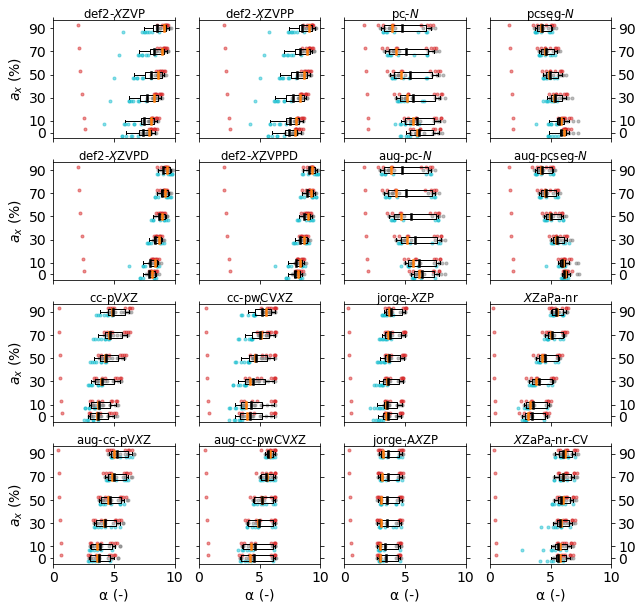

In [10]:
rows = np.array(xtplbases).reshape(4,4)

fig  = plt.figure(figsize=(10,10))
axes = []
fi = 1
for ri in range(len(rows)):
    for ci in range(len(rows[ri])):
        ac = 0.0
        axes.append(plt.subplot(len(rows), len(rows[ri]), fi))
        for ax in αs[ac].keys():
            bname = rows[ri][ci]
            axes[-1].boxplot([αs[ac][ax][bname]["a"]], positions=[round(ax)], 
                             vert=False, widths=5, showmeans=True, showfliers=False, whis=[10,90],
                             meanprops=meanprops, meanline=True, medianprops=medianprops, zorder=3)
            axes[-1].plot(αs[ac][ax][bname]["-"], [round(ax)-3]*len(αs[ac][ax][bname]["-"]), 
                          linestyle=" ", color="C9", marker=".", alpha=0.5)
            axes[-1].plot(αs[ac][ax][bname]["0"], [round(ax)]*len(αs[ac][ax][bname]["0"]), 
                          linestyle=" ", color="gray", marker=".", alpha=0.5)
            axes[-1].plot(αs[ac][ax][bname]["+"], [round(ax)+3]*len(αs[ac][ax][bname]["+"]), 
                          linestyle=" ", color="C3", marker=".", alpha=0.5)
            if len(αs[ac][ax][bname]["a"]) < totals[ac][ax]:
                log.warning(f"Extrapolation data for ac = {ac:5.1f}, ax = {ax:5.1f} with {bname} incomplete: {len(αs[ac][ax][bname]['a']):2d}/30")
        axes[-1].set_xlim(left=0, right=10)
        axes[-1].set_ylim(bottom=-5, top=97)
        axes[-1].set_title(prettifyBasis(bname), pad=2, fontsize="small")
        axes[-1].tick_params(left=True, right=True, top=True, bottom=True)
        axes[-1].tick_params(labelleft=False, labelright=False, labeltop=False, labelbottom=False)
        fi += 1
        if ri == len(rows) - 1:
            axes[-1].tick_params(labelbottom=True)
            axes[-1].set_xlabel("α (-)")
        if ci == 0:
            axes[-1].tick_params(labelleft=True)
            axes[-1].set_ylabel("$a_x$ (%)")
        elif ci == len(rows[ri]) - 1:
            axes[-1].tick_params(labelright=True)
#axes.set_ylabel("HFx %")
#axes.set_xlabel("α")
plt.show()
fig.savefig(os.path.join("..","output","fig_diat_alpha.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")

In [11]:
def getα(aa, α0, αx, αc):
    return α0 + aa[0]*αx + aa[1]*αc

lines = []
lines.append("\\begin{tabular}{l|r|r|r}")
lines.append("\\textbf{Family} & $\\alpha_0$ & $\\alpha_x$ & $\\alpha_c$ \\\\")
lines.append("\\hline")

for bname in ["cc-pvXz", "cc-pwcvXz", "aug-cc-pvXz", "aug-cc-pwcvXz", 
              "pc-N", "pcseg-N", "aug-pc-N", "aug-pcseg-N",
              "def2-Xzvp", "def2-Xzvpp", "def2-Xzvpd", "def2-Xzvppd",
              "jorge-Xzp", "jorge-aXzp", "Xzapa-nr", "Xzapa-nr-cv"]:
    xdata = [[],[]]
    ydata = []
    for ac in αs.keys():
        for ax in αs[ac].keys():
            xdata[0].append(ax/100)
            xdata[1].append(ac/100)
            ydata.append(np.mean(αs[ac][ax][bname]["a"]))
    try:
        popt, pcov = curve_fit(getα, xdata, ydata)
        print(prettifyBasis(bname))
        l = f'{prettifyBasis(bname):15s} & {popt[0]:5.3f} & {popt[1]:6.3f} & {popt[2]:6.3f} \\\\'
        lines.append(l)
    except ValueError:
        print(f"{bname:13s}: incomplete")
lines.append("\\hline")
lines.append("\\end{tabular}")
print("\n".join(lines))
with open(os.path.join("..", "output", "tab_basalpha.tex"), "w") as outfile:
    outfile.write("\n".join(lines))

cc-pV$X$Z
cc-pwCV$X$Z
aug-cc-pV$X$Z
aug-cc-pwCV$X$Z
pc-$N$
pcseg-$N$
aug-pc-$N$
aug-pcseg-$N$
def2-$X$ZVP
def2-$X$ZVPP
def2-$X$ZVPD
def2-$X$ZVPPD
jorge-$X$ZP
jorge-A$X$ZP
$X$ZaPa-nr
$X$ZaPa-nr-CV
\begin{tabular}{l|r|r|r}
\textbf{Family} & $\alpha_0$ & $\alpha_x$ & $\alpha_c$ \\
\hline
cc-pV$X$Z       & 3.622 &  1.511 &  0.005 \\
cc-pwCV$X$Z     & 4.157 &  1.192 & -0.048 \\
aug-cc-pV$X$Z   & 3.676 &  1.887 &  0.139 \\
aug-cc-pwCV$X$Z & 4.485 &  1.445 &  0.085 \\
pc-$N$          & 6.172 & -1.623 &  0.183 \\
pcseg-$N$       & 5.883 & -1.825 &  0.227 \\
aug-pc-$N$      & 6.390 & -1.874 &  0.260 \\
aug-pcseg-$N$   & 6.166 & -2.137 &  0.296 \\
def2-$X$ZVP     & 7.406 &  1.266 & -0.046 \\
def2-$X$ZVPP    & 7.408 &  1.267 & -0.046 \\
def2-$X$ZVPD    & 7.925 &  1.370 &  0.101 \\
def2-$X$ZVPPD   & 7.927 &  1.371 &  0.101 \\
jorge-$X$ZP     & 3.531 &  0.338 & -0.011 \\
jorge-A$X$ZP    & 3.386 &  0.245 &  0.033 \\
$X$ZaPa-nr      & 3.306 &  2.525 & -0.040 \\
$X$ZaPa-nr-CV   & 5.618 &  0.490 & -0.0